# 이미지 데이터 전처리 및 배치 제너레이터 생성

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 32
image_height = 500
image_width = 500
# 폴더 구조로 카테고리를 분류하기 위해
train_dir = '../catdog37/train'
test_dir = '../catdog37/test'


train = ImageDataGenerator(
    rescale = 1./255,
    # rotation_range = 10,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # shear_range=0.1,
    # zoom_range=0.1,
    validation_split = 0.2   # 검증 데이터 분할
    )
    
train_generator = train.flow_from_directory(train_dir,
                                            target_size = (image_height, image_width),
                                            color_mode = 'rgb',
                                            batch_size=BATCH_SIZE,
                                            seed=1,
                                            shuffle=True,
                                            class_mode="categorical",
                                            subset = 'training')   # training

validation_generator = train.flow_from_directory(train_dir,
                                            target_size = (image_height, image_width),
                                            color_mode = 'rgb',
                                            batch_size=BATCH_SIZE,
                                            seed=1,
                                            shuffle=True,
                                            class_mode="categorical",
                                            subset = 'validation')   # validation

test = ImageDataGenerator(rescale = 1./255)

test_generator = train.flow_from_directory(train_dir,
                                            target_size = (image_height, image_width),
                                            color_mode = 'rgb',
                                            batch_size=BATCH_SIZE,
                                            seed=1,
                                            shuffle=True,
                                            class_mode="categorical")

Found 2946 images belonging to 37 classes.
Found 734 images belonging to 37 classes.
Found 3680 images belonging to 37 classes.


In [3]:
# img, label = next(train_generator)

In [4]:
# img

In [5]:
# label

In [6]:
# 테스트 후 제너레이터를 다시 생성해야합니다.
# 배치를 수행했기에 훈련 데이터가 배치만큼 줄어듭니다.
# for data_batch, labels_batch in train_generator:
#     print('데이터 배치 크기: ', data_batch.shape)
#     print('레이블 배치 크기: ', labels_batch.shape)
#     break

## 모델 구성

In [3]:
import keras
from tensorflow.keras import layers

Using TensorFlow backend.


In [ ]:
inputs = keras.Input(shape=(image_height, image_width, 3))
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
outputs = layers.Dense(37, activation='softmax')(x)

model = keras.Model(inputs = inputs, outputs = outputs)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.summary()

## 모델 훈련

In [22]:
import os
import keras

EPOCHS = 30

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor = 'val_accuracy',
        patience = 6,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=os.path.join("../학습한 모델들/", "/my_conv_catdog37_try_1/my_conv_catdog37_try_1_{epoch:02d}_{val_accuracy:.2f}_{val_loss:.2f}.keras"),
        monitor='val_loss',
        save_best_only=True
    )
]

In [23]:
fit_history = model.fit(train_generator,
                        epochs=EPOCHS,
                        validation_data=validation_generator,
                        callbacks=callbacks)

Epoch 1/30
110/123 [=========================>....] - ETA: 19s - loss: 3.6537 - accuracy: 0.0224

KeyboardInterrupt: 

## 학습 곡선

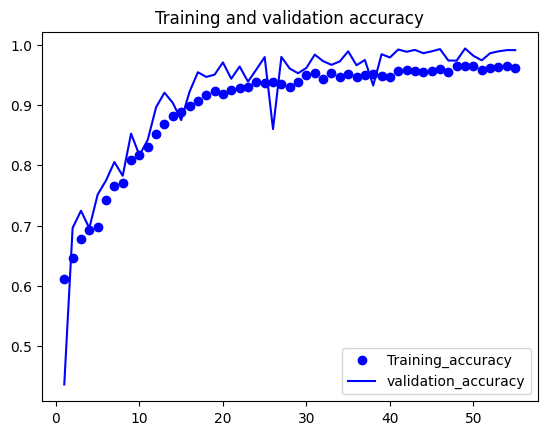

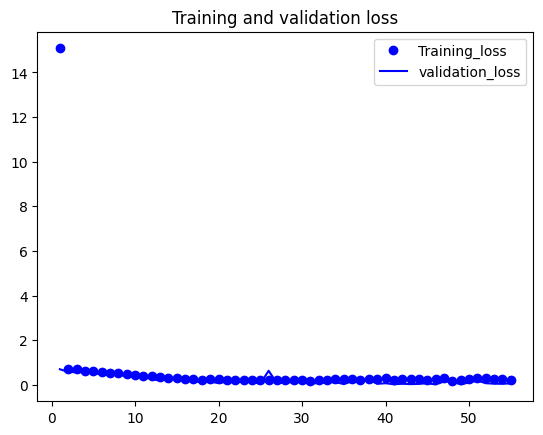

In [18]:
import matplotlib.pyplot as plt

accuracy = fit_history.history["accuracy"]
val_accuracy = fit_history.history["val_accuracy"]
loss = fit_history.history["loss"]
val_loss = fit_history.history["val_loss"]
epochs = range(1, len(accuracy)+1)

plt.plot(epochs, accuracy, "bo", label="Training_accuracy")
plt.plot(epochs, val_accuracy, "b-", label="validation_accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training_loss")
plt.plot(epochs, val_loss, "b-", label="validation_loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

## 모델 평가

In [11]:
test_model = keras.models.load_model('../학습한 모델들/my_conv_try_1_16_0.81_0.42/my_conv_try_1_16_0.81_0.42.keras')
test_loss, test_acc = test_model.evaluate(test_generator)
print(f'테스트 정확도: {test_acc:.3f}')
print(f'테스트 손실: {test_loss:.3f}')

230/230 [==============================] - 186s 807ms/step - loss: 0.3238 - accuracy: 0.8584
테스트 정확도: 0.858
테스트 손실: 0.324


# 사전 훈련된 모델 사용 ( InceptionV3 )

In [4]:
import keras
conv_base = keras.applications.InceptionV3(weights="imagenet", include_top=False)
conv_base.trainable = False

Using TensorFlow backend.


In [ ]:
conv_base.summary()

In [5]:
inputs = keras.Input(shape = (image_height, image_width, 3))
#x = keras.applications.inception_v3.preprocess_input(inputs)
x = conv_base(inputs)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Flatten()(x)
# x = keras.layers.Dense(512)(x)
outputs = keras.layers.Dense(37, activation = "softmax")(x)

model = keras.Model(inputs, outputs)
model.compile(loss = "categorical_crossentropy",
              optimizer = "rmsprop",
              metrics=["accuracy"])

## 모델 훈련

In [ ]:
import os
import keras

EPOCHS = 100

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor = 'val_accuracy',
        patience = 6,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=os.path.join("C:/Users/ligoan/OneDrive/바탕 화면/I/repository/quest/DLThon/학습한 모델들/my_conv_catdog37_try_3_inceptionV3_{epoch:02d}_{val_accuracy:.2f}_{val_loss:.2f}/my_conv_catdog37_try_3_inceptionV3_{epoch:02d}_{val_accuracy:.2f}_{val_loss:.2f}.keras"),
        monitor='val_loss',
        save_best_only=True
    )
]

fit_history = model.fit(train_generator,
                        epochs = EPOCHS,
                        validation_data = validation_generator,
                        callbacks=callbacks)

## 학습 곡선

In [ ]:
import matplotlib.pyplot as plt

accuracy = fit_history.history["accuracy"]
val_accuracy = fit_history.history["val_accuracy"]
loss = fit_history.history["loss"]
val_loss = fit_history.history["val_loss"]
epochs = range(1, len(accuracy)+1)

plt.plot(epochs, accuracy, "bo", label="Training_accuracy")
plt.plot(epochs, val_accuracy, "b-", label="validation_accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training_loss")
plt.plot(epochs, val_loss, "b-", label="validation_loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

# 사전 훈련된 모델 사용 | 규제 층 ( Dropout ) 제거, 이미지 크기 조정 500 -> 224

## 이미지 데이터 전처리

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 32
image_height = 224
image_width = 224
# 폴더 구조로 카테고리를 분류하기 위해
train_dir = '../catdog37/train'
test_dir = '../catdog37/test'


train = ImageDataGenerator(
    rescale = 1./255,
    # rotation_range = 10,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # shear_range=0.1,
    # zoom_range=0.1,
    validation_split = 0.2   # 검증 데이터 분할
    )
    
train_generator = train.flow_from_directory(train_dir,
                                            target_size = (image_height, image_width),
                                            color_mode = 'rgb',
                                            batch_size=BATCH_SIZE,
                                            seed=1,
                                            shuffle=True,
                                            class_mode="categorical",
                                            subset = 'training')   # training

validation_generator = train.flow_from_directory(train_dir,
                                            target_size = (image_height, image_width),
                                            color_mode = 'rgb',
                                            batch_size=BATCH_SIZE,
                                            seed=1,
                                            shuffle=True,
                                            class_mode="categorical",
                                            subset = 'validation')   # validation

test = ImageDataGenerator(rescale = 1./255)

test_generator = train.flow_from_directory(train_dir,
                                            target_size = (image_height, image_width),
                                            color_mode = 'rgb',
                                            batch_size=BATCH_SIZE,
                                            seed=1,
                                            shuffle=True,
                                            class_mode="categorical")

Found 2946 images belonging to 37 classes.
Found 734 images belonging to 37 classes.
Found 3680 images belonging to 37 classes.


## 모델 훈련

In [2]:
import keras
import os
import keras

conv_base = keras.applications.InceptionV3(weights="imagenet", include_top=False)
conv_base.trainable = False

inputs = keras.Input(shape = (image_height, image_width, 3))
#x = keras.applications.inception_v3.preprocess_input(inputs)
x = conv_base(inputs)
x = keras.layers.GlobalAveragePooling2D()(x)
# x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Flatten()(x)
# x = keras.layers.Dense(512)(x)
outputs = keras.layers.Dense(37, activation = "softmax")(x)

model = keras.Model(inputs, outputs)
model.compile(loss = "categorical_crossentropy",
              optimizer = "rmsprop",
              metrics=["accuracy"])

EPOCHS = 100

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor = 'val_accuracy',
        patience = 6,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=os.path.join("C:/Users/ligoan/OneDrive/바탕 화면/I/repository/quest/DLThon/학습한 모델들/my_conv_catdog37_try_4_inceptionV3_no_dropout_{epoch:02d}_{val_accuracy:.2f}_{val_loss:.2f}/my_conv_catdog37_try_4_inceptionV3_no_dropout_224_224_{epoch:02d}_{val_accuracy:.2f}_{val_loss:.2f}.keras"),
        monitor='val_loss',
        save_best_only=True
    )
]

fit_history = model.fit(train_generator,
                        epochs = EPOCHS,
                        validation_data = validation_generator,
                        callbacks=callbacks)

Using TensorFlow backend.


Epoch 1/100
93/93 [==============================] - 28s 230ms/step - loss: 1.8533 - accuracy: 0.5454 - val_loss: 0.4834 - val_accuracy: 0.8529
Epoch 2/100
93/93 [==============================] - 20s 215ms/step - loss: 0.3338 - accuracy: 0.8982 - val_loss: 0.4393 - val_accuracy: 0.8569
Epoch 3/100
93/93 [==============================] - 24s 263ms/step - loss: 0.2526 - accuracy: 0.9141 - val_loss: 0.3794 - val_accuracy: 0.8801
Epoch 4/100
93/93 [==============================] - 28s 303ms/step - loss: 0.1662 - accuracy: 0.9434 - val_loss: 0.4067 - val_accuracy: 0.8719
Epoch 5/100
93/93 [==============================] - 31s 335ms/step - loss: 0.1229 - accuracy: 0.9650 - val_loss: 0.4344 - val_accuracy: 0.8542
Epoch 6/100
93/93 [==============================] - 31s 331ms/step - loss: 0.0885 - accuracy: 0.9730 - val_loss: 0.4419 - val_accuracy: 0.8747
Epoch 7/100
93/93 [==============================] - 32s 348ms/step - loss: 0.0663 - accuracy: 0.9778 - val_loss: 0.3959 - val_accuracy:

## 학습 곡선

In [ ]:
import matplotlib.pyplot as plt

accuracy = fit_history.history["accuracy"]
val_accuracy = fit_history.history["val_accuracy"]
loss = fit_history.history["loss"]
val_loss = fit_history.history["val_loss"]
epochs = range(1, len(accuracy)+1)

plt.plot(epochs, accuracy, "bo", label="Training_accuracy")
plt.plot(epochs, val_accuracy, "b-", label="validation_accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training_loss")
plt.plot(epochs, val_loss, "b-", label="validation_loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

# 사전 훈련된 모델 사용 | 규제 층 추가 ( regularizer ), 이미지 크기 조정 500 -> 224

In [13]:
import keras
conv_base = keras.applications.InceptionV3(weights="imagenet", include_top=False)
conv_base.trainable = False

## 이미지 데이터 전처리

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 32
image_height = 224
image_width = 224
# 폴더 구조로 카테고리를 분류하기 위해
train_dir = '../catdog37/train'
test_dir = '../catdog37/test'


train = ImageDataGenerator(
    rescale = 1./255,
    # rotation_range = 10,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # shear_range=0.1,
    # zoom_range=0.1,
    validation_split = 0.2   # 검증 데이터 분할
    )
    
train_generator = train.flow_from_directory(train_dir,
                                            target_size = (image_height, image_width),
                                            color_mode = 'rgb',
                                            batch_size=BATCH_SIZE,
                                            seed=1,
                                            shuffle=True,
                                            class_mode="categorical",
                                            subset = 'training')   # training

validation_generator = train.flow_from_directory(train_dir,
                                            target_size = (image_height, image_width),
                                            color_mode = 'rgb',
                                            batch_size=BATCH_SIZE,
                                            seed=1,
                                            shuffle=True,
                                            class_mode="categorical",
                                            subset = 'validation')   # validation

test = ImageDataGenerator(rescale = 1./255)

test_generator = train.flow_from_directory(train_dir,
                                            target_size = (image_height, image_width),
                                            color_mode = 'rgb',
                                            batch_size=BATCH_SIZE,
                                            seed=1,
                                            shuffle=True,
                                            class_mode="categorical")

Found 2946 images belonging to 37 classes.
Found 734 images belonging to 37 classes.
Found 3680 images belonging to 37 classes.


## 모델 훈련

In [ ]:
import keras
import os
import keras

conv_base = keras.applications.InceptionV3(weights="imagenet", include_top=False)
conv_base.trainable = False

inputs = keras.Input(shape = (image_height, image_width, 3))
#x = keras.applications.inception_v3.preprocess_input(inputs)
x = conv_base(inputs)
x = keras.layers.GlobalAveragePooling2D()(x)
# x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(37, kernel_regularizer=keras.regularizers.l2(0.01))(x)
# x = keras.layers.Dense(512)(x)
outputs = keras.layers.Dense(37, activation = "softmax")(x)

model = keras.Model(inputs, outputs)
model.compile(loss = "categorical_crossentropy",
              optimizer = "rmsprop",
              metrics=["accuracy"])

EPOCHS = 100

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor = 'val_accuracy',
        patience = 6,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=os.path.join("C:/Users/ligoan/OneDrive/바탕 화면/I/repository/quest/DLThon/학습한 모델들/my_conv_catdog37_try_5_inceptionV3_regularizer_224_224_{epoch:02d}_{val_accuracy:.2f}_{val_loss:.2f}/my_conv_catdog37_try_4_inceptionV3_regularizer_224_224_{epoch:02d}_{val_accuracy:.2f}_{val_loss:.2f}.keras"),
        monitor='val_loss',
        save_best_only=True
    )
]

fit_history = model.fit(train_generator,
                        epochs = EPOCHS,
                        validation_data = validation_generator,
                        callbacks=callbacks)

## 학습 곡선

In [ ]:
import matplotlib.pyplot as plt

accuracy = fit_history.history["accuracy"]
val_accuracy = fit_history.history["val_accuracy"]
loss = fit_history.history["loss"]
val_loss = fit_history.history["val_loss"]
epochs = range(1, len(accuracy)+1)

plt.plot(epochs, accuracy, "bo", label="Training_accuracy")
plt.plot(epochs, val_accuracy, "b-", label="validation_accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training_loss")
plt.plot(epochs, val_loss, "b-", label="validation_loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

# 사전 훈련된 모델 사용 | Flatten 층 제거 | 입력 층 이미지 크기 제한 해제

In [27]:
import keras
conv_base = keras.applications.InceptionV3(weights="imagenet", include_top=False)
# conv_base.trainable = False

## 이미지 전처리

In [39]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 32
image_height = 224
image_width = 224
# 폴더 구조로 카테고리를 분류하기 위해
train_dir = '../catdog37/train'
test_dir = '../catdog37/test'


train = ImageDataGenerator(
    rescale = 1./255,
    # rotation_range = 10,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # shear_range=0.1,
    # zoom_range=0.1,
    validation_split = 0.2   # 검증 데이터 분할
    )
    
train_generator = train.flow_from_directory(train_dir,
                                            target_size = (image_height, image_width),
                                            color_mode = 'rgb',
                                            batch_size=BATCH_SIZE,
                                            seed=1,
                                            shuffle=True,
                                            class_mode="categorical",
                                            subset = 'training')   # training

validation_generator = train.flow_from_directory(train_dir,
                                            target_size = (image_height, image_width),
                                            color_mode = 'rgb',
                                            batch_size=BATCH_SIZE,
                                            seed=1,
                                            shuffle=True,
                                            class_mode="categorical",
                                            subset = 'validation')   # validation

test = ImageDataGenerator(rescale = 1./255)

test_generator = train.flow_from_directory(train_dir,
                                            target_size = (image_height, image_width),
                                            color_mode = 'rgb',
                                            batch_size=BATCH_SIZE,
                                            seed=1,
                                            shuffle=True,
                                            class_mode="categorical")

Found 2946 images belonging to 37 classes.
Found 734 images belonging to 37 classes.
Found 3680 images belonging to 37 classes.


## 모델 훈련

In [ ]:
import keras
import os
import keras

conv_base = keras.applications.InceptionV3(weights="imagenet", include_top=False)
conv_base.trainable = False

inputs = keras.Input(shape=(None, None, 3))
#x = keras.applications.inception_v3.preprocess_input(inputs)
x = conv_base(inputs)
x = keras.layers.GlobalAveragePooling2D()(x)
# x = keras.layers.Dropout(0.5)(x)
# x = keras.layers.Flatten()(x)
outputs = keras.layers.Dense(37, activation = "softmax")(x)

model = keras.Model(inputs, outputs)
model.compile(loss = "categorical_crossentropy",
              optimizer = "rmsprop",
              metrics=["accuracy"])

EPOCHS = 150

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor = 'val_accuracy',
        patience = 10,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=os.path.join("C:/Users/ligoan/OneDrive/바탕 화면/I/repository/quest/DLThon/학습한 모델들/my_conv_catdog37_try_6_inceptionV3_no_limit_input_size_224_224_{epoch:02d}_{val_accuracy:.2f}_{val_loss:.2f}/my_conv_catdog37_try_6_inceptionV3_no_limit_input_size_224_224_{epoch:02d}_{val_accuracy:.2f}_{val_loss:.2f}.keras"),
        monitor='val_loss',
        save_best_only=True
    )
]

fit_history = model.fit(train_generator,
                        epochs = EPOCHS,
                        validation_data = validation_generator,
                        callbacks=callbacks)

## 학습 곡선

In [ ]:
import matplotlib.pyplot as plt

accuracy = fit_history.history["accuracy"]
val_accuracy = fit_history.history["val_accuracy"]
loss = fit_history.history["loss"]
val_loss = fit_history.history["val_loss"]
epochs = range(1, len(accuracy)+1)

plt.plot(epochs, accuracy, "bo", label="Training_accuracy")
plt.plot(epochs, val_accuracy, "b-", label="validation_accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training_loss")
plt.plot(epochs, val_loss, "b-", label="validation_loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

# 사전 훈련된 모델 사용 | 규제 층 추가 ( Dropout 0.5 ) | Flatten 층 제거 | 입력 층 이미지 크기 제한 해제

In [46]:
import keras
conv_base = keras.applications.InceptionV3(weights="imagenet", include_top=False)
conv_base.trainable = False

## 이미지 전처리

In [47]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 32
image_height = 224
image_width = 224
# 폴더 구조로 카테고리를 분류하기 위해
train_dir = '../catdog37/train'
test_dir = '../catdog37/test'


train = ImageDataGenerator(
    rescale = 1./255,
    # rotation_range = 10,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # shear_range=0.1,
    # zoom_range=0.1,
    validation_split = 0.2   # 검증 데이터 분할
    )
    
train_generator = train.flow_from_directory(train_dir,
                                            target_size = (image_height, image_width),
                                            color_mode = 'rgb',
                                            batch_size=BATCH_SIZE,
                                            seed=1,
                                            shuffle=True,
                                            class_mode="categorical",
                                            subset = 'training')   # training

validation_generator = train.flow_from_directory(train_dir,
                                            target_size = (image_height, image_width),
                                            color_mode = 'rgb',
                                            batch_size=BATCH_SIZE,
                                            seed=1,
                                            shuffle=True,
                                            class_mode="categorical",
                                            subset = 'validation')   # validation

test = ImageDataGenerator(rescale = 1./255)

test_generator = train.flow_from_directory(train_dir,
                                            target_size = (image_height, image_width),
                                            color_mode = 'rgb',
                                            batch_size=BATCH_SIZE,
                                            seed=1,
                                            shuffle=True,
                                            class_mode="categorical")

Found 2946 images belonging to 37 classes.
Found 734 images belonging to 37 classes.
Found 3680 images belonging to 37 classes.


## 모델 훈련

In [ ]:
import keras
import os
import keras

conv_base = keras.applications.InceptionV3(weights="imagenet", include_top=False)
conv_base.trainable = False

inputs = keras.Input(shape=(None, None, 3))
#x = keras.applications.inception_v3.preprocess_input(inputs)
x = conv_base(inputs)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.7)(x)
# x = keras.layers.Flatten()(x)
outputs = keras.layers.Dense(37, activation = "softmax")(x)

model = keras.Model(inputs, outputs)
model.compile(loss = "categorical_crossentropy",
              optimizer = "rmsprop",
              metrics=["accuracy"])

EPOCHS = 150

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor = 'val_accuracy',
        patience = 10,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=os.path.join("C:/Users/ligoan/OneDrive/바탕 화면/I/repository/quest/DLThon/학습한 모델들/my_conv_catdog37_try_7_inceptionV3_no_limit_input_size_dropout_224_224_{epoch:02d}_{val_accuracy:.2f}_{val_loss:.2f}/my_conv_catdog37_try_7_inceptionV3_no_limit_input_size_dropout_224_224_{epoch:02d}_{val_accuracy:.2f}_{val_loss:.2f}.keras"),
        monitor='val_loss',
        save_best_only=True
    )
]

fit_history = model.fit(train_generator,
                        epochs = EPOCHS,
                        validation_data = validation_generator,
                        callbacks=callbacks)

## 학습 곡선

In [ ]:
import matplotlib.pyplot as plt

accuracy = fit_history.history["accuracy"]
val_accuracy = fit_history.history["val_accuracy"]
loss = fit_history.history["loss"]
val_loss = fit_history.history["val_loss"]
epochs = range(1, len(accuracy)+1)

plt.plot(epochs, accuracy, "bo", label="Training_accuracy")
plt.plot(epochs, val_accuracy, "b-", label="validation_accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training_loss")
plt.plot(epochs, val_loss, "b-", label="validation_loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

# 사전 훈련된 모델에 데이터 증식 사용하기

In [1]:
import keras
conv_base = keras.applications.InceptionV3(weights="imagenet", include_top=False)
conv_base.trainable = False

Using TensorFlow backend.


## 이미지 증식

In [8]:
import tensorflow as tf
from keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory

BATCH_SIZE = 32
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

data_augmentation = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomTranslation(0.1, 0.1),
        layers.experimental.preprocessing.RandomZoom(0.2)
    ]
)



TRAIN_DIR = '../catdog/train'
TEST_DIR = '../catdog/test'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    validation_split=0.2,
    subset="training",
    seed=123
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    validation_split=0.2,
    subset="validation",
    seed=123
)

test_ds = image_dataset_from_directory(
    TEST_DIR,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
)

train_ds = train_ds.prefetch(BATCH_SIZE)
val_ds = train_ds.prefetch(BATCH_SIZE)
test_ds = test_ds.prefetch(BATCH_SIZE)

Found 3680 files belonging to 2 classes.
Using 2944 files for training.
Found 3680 files belonging to 2 classes.
Using 736 files for validation.
Found 3669 files belonging to 2 classes.


## 모델 훈련

In [ ]:
import keras
import os
import keras

conv_base = keras.applications.InceptionV3(weights="imagenet", include_top=False)
conv_base.trainable = False

inputs = keras.Input(shape=(None, None, 3))
x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(1./255)(x)
#x = keras.applications.inception_v3.preprocess_input(inputs)
x = conv_base(x)
x = keras.layers.GlobalAveragePooling2D()(x)
# x = keras.layers.Dropout(0.5)(x)
# x = keras.layers.Flatten()(x)
outputs = keras.layers.Dense(37, activation = "softmax")(x)

model = keras.Model(inputs, outputs)
model.compile(loss = "categorical_crossentropy",
              optimizer = "rmsprop",
              metrics=["accuracy"])

EPOCHS = 150

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor = 'val_accuracy',
        patience = 10,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=os.path.join("C:/Users/ligoan/OneDrive/바탕 화면/I/repository/quest/DLThon/학습한 모델들/my_conv_catdog37_try_8_inceptionV3_image_aug_no_limit_input_size_224_224_{epoch:02d}_{val_accuracy:.2f}_{val_loss:.2f}/my_conv_catdog37_try_6_inceptionV3__image_aug_no_limit_input_size_224_224_{epoch:02d}_{val_accuracy:.2f}_{val_loss:.2f}.keras"),
        monitor='val_loss',
        save_best_only=True
    )
]

fit_history = model.fit(train_ds,
                        epochs = EPOCHS,
                        validation_data = val_ds,
                        callbacks=callbacks)

## 모델 평가

In [18]:
import keras
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# 모델 파일 경로
model_path = 'C:/Users/ligoan/OneDrive/바탕 화면/I/repository/quest/DLThon/학습한 모델들/my_conv_catdog37_try_8_inceptionV3_image_aug_no_limit_input_size_224_224_75_0.97_0.10/my_conv_catdog37_try_6_inceptionV3__image_aug_no_limit_input_size_224_224_75_0.97_0.10.keras'

# 모델 로드
test_model = keras.models.load_model(model_path)

# 테스트 데이터 예측
predictions = test_model.predict(test_ds)

In [22]:
predicted_labels.shape

(3669,)

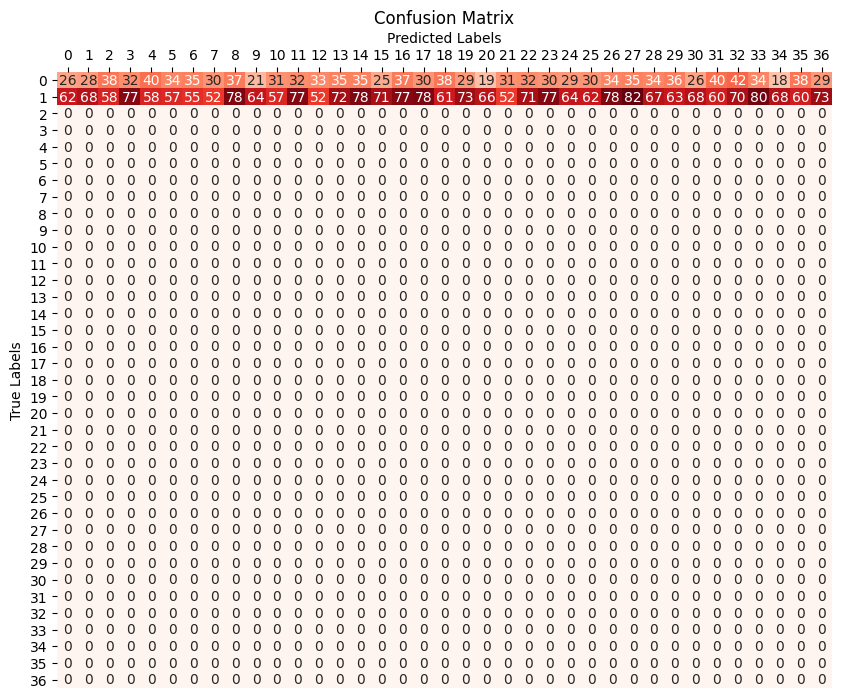

In [21]:
predicted_labels = np.argmax(predictions, axis=1)

# 실제 레이블 가져오기
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

# 혼동 행렬 생성
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# 혼동 행렬 시각화
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', cbar=False)

# x축과 y축 레이블 설정
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

# x축 레이블을 타이틀 바로 아래로 이동
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

plt.title('Confusion Matrix')
plt.show()

# 사전 훈련된 모델에 사용 | Dense 64, 37 Epoch 100 | 빠른 특성 추출

## 이미지 전처리

In [177]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 32
image_height = 224
image_width = 224
# 폴더 구조로 카테고리를 분류하기 위해
train_dir = '../catdog37/train'
test_dir = '../catdog37/test'


train = ImageDataGenerator(
    rescale = 1./255,
    # rotation_range = 10,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # shear_range=0.1,
    # zoom_range=0.1,
    validation_split = 0.2   # 검증 데이터 분할
    )
    
train_generator = train.flow_from_directory(train_dir,
                                            target_size = (image_height, image_width),
                                            color_mode = 'rgb',
                                            batch_size=BATCH_SIZE,
                                            seed=1,
                                            shuffle=True,
                                            class_mode="categorical",
                                            subset = 'training')   # training

validation_generator = train.flow_from_directory(train_dir,
                                            target_size = (image_height, image_width),
                                            color_mode = 'rgb',
                                            batch_size=BATCH_SIZE,
                                            seed=1,
                                            shuffle=True,
                                            class_mode="categorical",
                                            subset = 'validation')   # validation

test = ImageDataGenerator(rescale = 1./255)

test_generator = test.flow_from_directory(test_dir,
                                            target_size = (image_height, image_width),
                                            color_mode = 'rgb',
                                            batch_size=BATCH_SIZE,
                                            seed=1,
                                            class_mode="categorical")

Found 2946 images belonging to 37 classes.
Found 734 images belonging to 37 classes.
Found 3669 images belonging to 37 classes.


In [2]:
# import numpy as np
# import keras
# import os
# import keras

# conv_base = keras.applications.InceptionV3(weights="imagenet", include_top=False)
# conv_base.trainable = False

# def get_features_and_labels(dataset):
#   all_features = []
#   all_labels = []
#   for images, labels in dataset:
#     preprocessed_images = keras.applications.inception_v3.preprocess_input(images)
#     features = conv_base.predict(preprocessed_images)
#     all_features.append(features)
#     all_labels.append(labels)
#   return np.concatenate(all_features), np.concatenate(all_labels)

# train_features, train_labels = get_features_and_labels(train_generator)
# validation_features, validation_labels = get_features_and_labels(validation_generator)
# test_features, test_labels = get_features_and_labels(test_generator)

Using TensorFlow backend.


## 추출한 특성 로딩

In [126]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from sklearn.utils import shuffle
file_path = 'C:/Users/ligoan/OneDrive/바탕 화면/I/repository/quest/DLThon/이미지 전처리 결과/Embedded images_by_inceptionV3.csv'


## 데이터 전처리

In [165]:
embedded_images = pd.read_csv(file_path)
embedded_images.drop(['image name', 'image'], axis=1, inplace=True)
embedded_images = pd.get_dummies(embedded_images, columns = ['category'])

# Shuffle the data
embedded_images = shuffle(embedded_images, random_state=42)

# Convert to numpy array after shuffling
embedded_images = np.array(embedded_images)

train_set = np.array(embedded_images[:2945])
val_set = np.array(embedded_images[2945:])

num_categories = 37
train_labels = train_set[:, -num_categories:]
train_data = train_set[:, :-num_categories]
val_labels = val_set[:, -num_categories:]
val_data = val_set[:, :-num_categories]

# Convert to TensorFlow Datasets
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size).repeat()

val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels))
val_dataset = val_dataset.batch(batch_size)

## 모델 훈련

In [ ]:
import os
from keras import regularizers

inputs = keras.Input(shape=(2048,))
# x = keras.layers.Dropout(0.5)(inputs)
# x = keras.layers.Dense(64, activation='relu')(inputs)
# x = keras.layers.Dropout(0.)(inputs)
# x = keras.layers.Dense(64, activation = "relu", kernel_regularizer=regularizers.l2(0.001))(inputs)
# x = keras.layers.Dense(64, activation='relu')(inputs)
# x = keras.layers.Dense(64)(inputs)
# x = keras.layers.Dense(37)(inputs)
outputs = keras.layers.Dense(37, activation = "softmax")(inputs)

model = keras.Model(inputs, outputs)
model.compile(loss = "categorical_crossentropy",
              optimizer = "adam",
              metrics=["accuracy"])

EPOCHS = 200

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor = 'val_accuracy',
        patience = 30,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=os.path.join("C:/Users/ligoan/OneDrive/바탕 화면/I/repository/quest/DLThon/학습한 모델들/my_conv_catdog37_try_9_fast_featrue_224_224_{epoch:02d}_{val_accuracy:.2f}_{val_loss:.2f}/my_conv_catdog37_try_9_fast_featrue_224_224_{epoch:02d}_{val_accuracy:.2f}_{val_loss:.2f}.keras"),
        monitor='val_loss',
        save_best_only=True
    )
]

steps_per_epoch = len(train_data) // batch_size
validation_steps = len(val_data) // batch_size

fit_history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    shuffle=True,
    callbacks=callbacks
)

## 학습 곡선

In [ ]:
import matplotlib.pyplot as plt

accuracy = fit_history.history["accuracy"]
val_accuracy = fit_history.history["val_accuracy"]
loss = fit_history.history["loss"]
val_loss = fit_history.history["val_loss"]
epochs = range(1, len(accuracy)+1)

plt.plot(epochs, accuracy, "bo", label="Training_accuracy")
plt.plot(epochs, val_accuracy, "b-", label="validation_accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training_loss")
plt.plot(epochs, val_loss, "b-", label="validation_loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

## 모델 평가

In [256]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 32
image_height = 224
image_width = 224
# 폴더 구조로 카테고리를 분류하기 위해
train_dir = '../catdog37/train'
test_dir = '../catdog37/test'


train = ImageDataGenerator(
    rescale = 1./255,
    # rotation_range = 10,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # shear_range=0.1,
    # zoom_range=0.1,
    validation_split = 0.2   # 검증 데이터 분할
    )
    
train_generator = train.flow_from_directory(train_dir,
                                            target_size = (image_height, image_width),
                                            color_mode = 'rgb',
                                            batch_size=BATCH_SIZE,
                                            seed=1,
                                            shuffle=True,
                                            class_mode="categorical",
                                            subset = 'training')   # training

validation_generator = train.flow_from_directory(train_dir,
                                            target_size = (image_height, image_width),
                                            color_mode = 'rgb',
                                            batch_size=BATCH_SIZE,
                                            seed=1,
                                            shuffle=True,
                                            class_mode="categorical",
                                            subset = 'validation')   # validation

test = ImageDataGenerator(rescale = 1./255)

test_generator = test.flow_from_directory(test_dir,
                                            target_size = (image_height, image_width),
                                            color_mode = 'rgb',
                                            batch_size=BATCH_SIZE,
                                            seed=1,
                                            shuffle=True,
                                            class_mode="categorical")

Found 2946 images belonging to 37 classes.
Found 734 images belonging to 37 classes.
Found 3669 images belonging to 37 classes.


In [ ]:
import os
import keras

conv_base = keras.applications.InceptionV3(weights="imagenet", include_top=False)
conv_base.trainable = False
model_path = "C:/Users/ligoan/OneDrive/바탕 화면/I/repository/quest/DLThon/학습한 모델들/my_conv_catdog37_try_9_fast_featrue_224_224_24_0.92_0.22/my_conv_catdog37_try_9_fast_featrue_224_224_24_0.92_0.22.keras"
image_classifier = tf.keras.models.load_model(model_path)
image_classifier.trainable = False

inputs = keras.Input(shape=(None, None, 3))
#x = keras.applications.inception_v3.preprocess_input(inputs)
x = conv_base(inputs)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = image_classifier(x)
model=keras.Model(inputs=inputs, outputs=outputs)

model = keras.Model(inputs, outputs)
model.compile(loss = "categorical_crossentropy",
              optimizer = "adam",
              metrics=["accuracy"])


In [313]:
model_path = "C:/Users/ligoan/OneDrive/바탕 화면/I/repository/quest/DLThon/학습한 모델들/xception/xception.keras"
model = tf.keras.models.load_model(model_path)
model.trainable = False


OSError: SavedModel file does not exist at: C:/Users/ligoan/OneDrive/바탕 화면/I/repository/quest/DLThon/학습한 모델들/xception/xception.keras/{saved_model.pbtxt|saved_model.pb}

In [ ]:
model.summary()

In [304]:
# 테스트 데이터 예측
predictions = model.predict(test_generator)

In [305]:
# Create an array of zeros with the same shape as predicted_labels
one_hot_labels = np.zeros_like(predictions)

# Find the index of the maximum value in each row
max_indices = np.argmax(predictions, axis=1)

# Set the maximum value in each row to 1
one_hot_labels[np.arange(predictions.shape[0]), max_indices] = 1

print(one_hot_labels.shape)

(3669, 37)


In [306]:
# 테스트 데이터 평가
evaluation = model.evaluate(test_generator)

115/115 [==============================] - 26s 211ms/step - loss: 0.3990 - accuracy: 0.8782


In [307]:
import numpy as np

# Assuming `one_hot_labels` is your original matrix generated from predicted labels
# Example:
# one_hot_labels = np.random.rand(1000, 10)  # For demonstration, a matrix with 1000 rows and 10 columns

# Define the ranges
ranges = [
    98, 100, 100, 100, 100, 100, 100, 88, 99, 100, 100, 97, 100, 100, 100, 100, 100, 100, 99, 100, 100, 100,
    100, 100, 100, 100, 100, 100, 100, 100, 99, 100, 100, 100, 89, 100, 100
]

# Check the total number of rows to ensure no index error
if sum(ranges) > one_hot_labels.shape[0]:
    raise ValueError("The total number of rows to be summed exceeds the number of rows in the matrix.")

# Generate the new matrix
new_matrix = []
start_index = 0

# Process the first range (98 rows from the beginning to the 0th row)
end_index = start_index + ranges[0]
summed_row = np.sum(one_hot_labels[start_index:end_index, :], axis=0)
new_matrix.append(summed_row)
start_index = end_index

# Process the remaining ranges
for r in ranges[1:]:
    end_index = start_index + r
    summed_row = np.sum(one_hot_labels[start_index:end_index, :], axis=0)
    new_matrix.append(summed_row)
    start_index = end_index

new_matrix = np.array(new_matrix)

print("Original matrix shape:", one_hot_labels.shape)
print("New matrix shape:", new_matrix.shape)


Original matrix shape: (3669, 37)
New matrix shape: (37, 37)


In [308]:
sum(new_matrix[0])

98.0

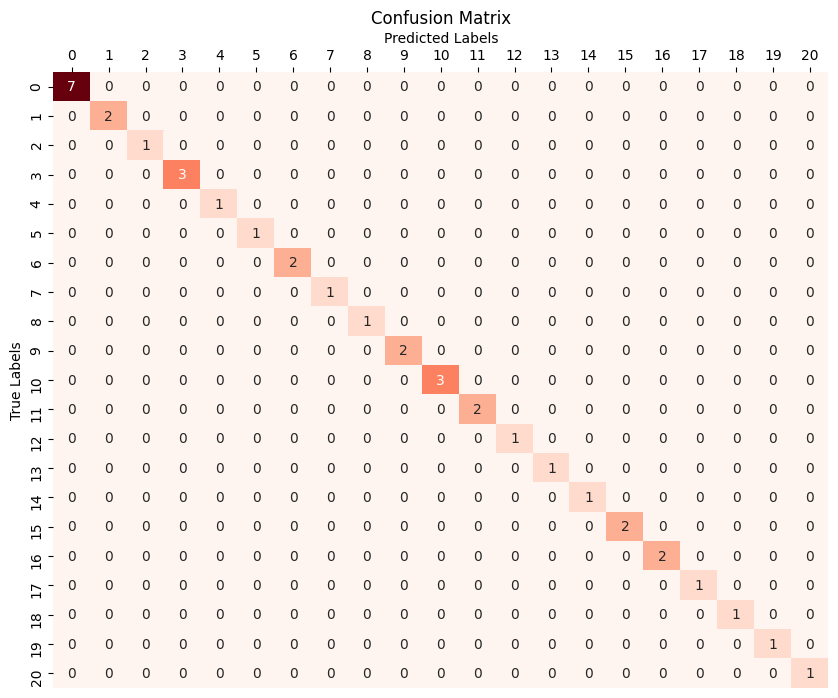

In [309]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

breeds = [
    "Abyssinian",
    "american_bulldog",
    "american_pit_bull_terrier",
    "basset_hound",
    "beagle",
    "Bengal",
    "Birman",
    "Bombay",
    "boxer",
    "British_Shorthair",
    "chihuahua",
    "Egyptian_Mau",
    "english_cocker_spaniel",
    "english_setter",
    "german_shorthaired",
    "great_pyrenees",
    "havanese",
    "japanese_chin",
    "keeshond",
    "leonberger",
    "Maine_Coon",
    "miniature_pinscher",
    "newfoundland",
    "Persian",
    "pomeranian",
    "pug",
    "Ragdoll",
    "Russian_Blue",
    "saint_bernard",
    "samoyed",
    "scottish_terrier",
    "shiba_inu",
    "Siamese",
    "Sphynx",
    "staffordshire_bull_terrier",
    "wheaten_terrier",
    "yorkshire_terrier"
]

# Create a mapping from breed names to numerical labels
breed_to_label = {breed: idx for idx, breed in enumerate(breeds)}

# Assuming you have the original true labels for the one_hot_labels
original_true_labels = np.argmax(one_hot_labels, axis=1)  # Example: true labels from one_hot_labels

# Generate true labels for the new_matrix
true_labels = []
start_index = 0
for r in ranges:
    end_index = start_index + r
    # Assuming the true label for the summed row is the most frequent label in the range
    true_label = np.bincount(original_true_labels[start_index:end_index]).argmax()
    true_labels.append(true_label)
    start_index = end_index

true_labels = np.array(true_labels)
predicted_labels = np.argmax(new_matrix, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', cbar=False)

# Set x-axis and y-axis labels
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

# Move x-axis labels just below the title
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

plt.title('Confusion Matrix')
plt.show()


In [310]:
import pandas as pd
confusion_matrix = pd.DataFrame(new_matrix)

In [311]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

conf_matrix_df = pd.DataFrame(new_matrix, index=breeds, columns=range(len(breeds))).astype(int)


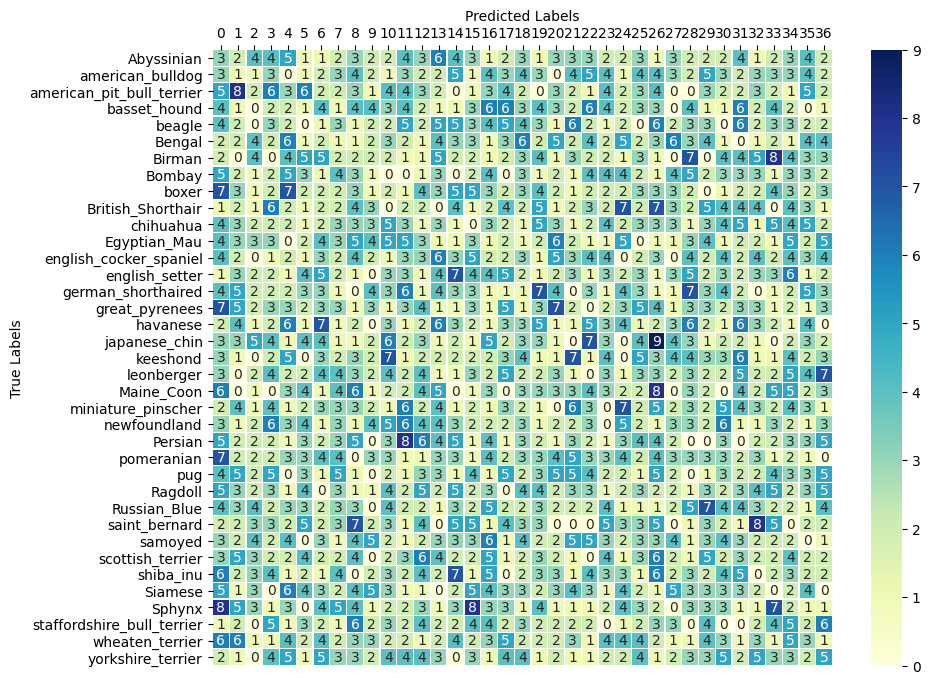

In [312]:
# Visualize confusion matrix
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='YlGnBu',linewidth = '.2')

# Set x-axis and y-axis labels
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

# Move x-axis labels just below the title
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

plt.show()

# 이미지 증식과 드롭아웃을 포함한 컨브넷 만들기

In [7]:
import keras
import tensorflow as tf
from keras import layers

In [8]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs = inputs, outputs = outputs)

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500, 500, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 498, 498, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 249, 249, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 247, 247, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 123, 123, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 121, 121, 128)     73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 60, 60, 128)       0     

# 규제를 추가한 컨브넷 훈련

In [1]:
import os
import keras

EPOCHS = 100

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor = 'val_accuracy',
        patience = 6,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=os.path.join("../학습한 모델들/", "my_conv_try_2_{epoch:02d}_{val_accuracy:.2f}_{val_loss:.2f}.keras"),
        monitor='val_loss',
        save_best_only=True
    )
]

KeyboardInterrupt: 

In [ ]:
fit_history = model.fit(train_ds,
                        epochs=EPOCHS,
                        validation_data=val_ds,
                        callbacks=callbacks)

# 학습 곡선

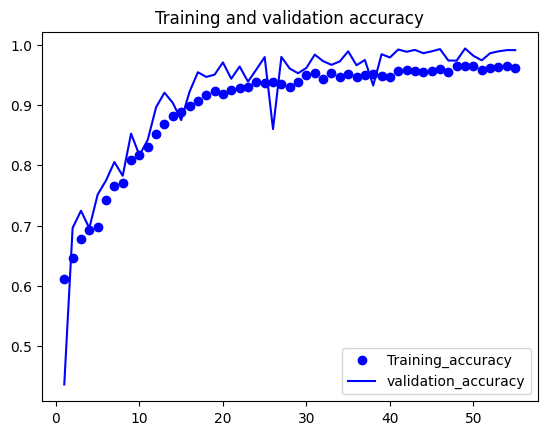

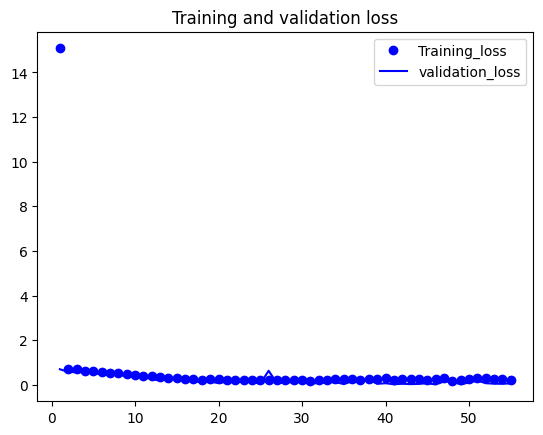

In [19]:
import matplotlib.pyplot as plt

accuracy = fit_history.history["accuracy"]
val_accuracy = fit_history.history["val_accuracy"]
loss = fit_history.history["loss"]
val_loss = fit_history.history["val_loss"]
epochs = range(1, len(accuracy)+1)

plt.plot(epochs, accuracy, "bo", label="Training_accuracy")
plt.plot(epochs, val_accuracy, "b-", label="validation_accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training_loss")
plt.plot(epochs, val_loss, "b-", label="validation_loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

# 모델 평가

In [8]:
test_model = keras.models.load_model('../학습한 모델들/my_conv_try_2_46_0.99_0.02/my_conv_try_2_46_0.99_0.02.keras')
test_loss, test_acc = test_model.evaluate(test_ds)
print(f'테스트 정확도: {test_acc:.3f}')
print(f'테스트 손실: {test_loss:.3f}')

123/123 [==============================] - 24s 147ms/step - loss: 0.0178 - accuracy: 0.9929
테스트 정확도: 0.993
테스트 손실: 0.018
